# Newsvendor Using LDR Package

In [1]:
using Distributions
using Plots
using JSON
using JuMP
using HiGHS
using Statistics
using Random
using LinearDecisionRules
using LinearAlgebra

In [2]:
buy_cost = 10
return_value = 8
sell_value = 15

demand_max = 120
demand_min = 80

ldr = LinearDecisionRules.LDRModel(HiGHS.Optimizer)
set_silent(ldr)

@variable(ldr, buy >= 0, LinearDecisionRules.FirstStage)
@variable(ldr, sell >= 0)
@variable(ldr, ret >= 0)
@variable(ldr, demand in LinearDecisionRules.Uncertainty(
        distribution = Uniform(demand_min, demand_max)
    )
)

@constraint(ldr, sell + ret <= buy)
@constraint(ldr, sell <= demand)

@objective(ldr, Max,
    - buy_cost * buy
    + return_value * ret
    + sell_value * sell
)

optimize!(ldr)

@show LinearDecisionRules.get_decision(ldr, buy)
@show LinearDecisionRules.get_decision(ldr, buy, demand)
@show LinearDecisionRules.get_decision(ldr, sell)
@show LinearDecisionRules.get_decision(ldr, sell, demand)
@show LinearDecisionRules.get_decision(ldr, ret)
@show LinearDecisionRules.get_decision(ldr, ret, demand)
@show objective_value(ldr)

LinearDecisionRules.get_decision(ldr, buy) = 120.0
LinearDecisionRules.get_decision(ldr, buy, demand) = 0.0
LinearDecisionRules.get_decision(ldr, sell) = 0.0
LinearDecisionRules.get_decision(ldr, sell, demand) = 1.0
LinearDecisionRules.get_decision(ldr, ret) = 120.0
LinearDecisionRules.get_decision(ldr, ret, demand) = -1.0
objective_value(ldr) = 460.0


460.0

## Extending problem to piecewise version

### Copy necessary data

In [3]:
ABC = ldr.ext[:_LDR_ABC]

ABC_copy = deepcopy(ABC)
ABC_data = (; 
    Ae = ABC_copy.Ae,
    Be = ABC_copy.Be,
    Au = ABC_copy.Au,
    Bu = ABC_copy.Bu,
    Wu = ABC_copy.Wu,
    ub = ABC_copy.ub,
    hu = ABC_copy.hu,
    Al = ABC_copy.Al,
    Bl = ABC_copy.Bl,
    Wl = ABC_copy.Wl,
    lb = ABC_copy.lb,
    hl = ABC_copy.hl,
    C  = ABC_copy.C,
    xu = ABC_copy.xu,
    xl = ABC_copy.xl
)
@show typeof(ABC)

typeof(ABC) = @NamedTuple{Ae::SparseArrays.SparseMatrixCSC{Float64, Int64}, Be::SparseArrays.SparseMatrixCSC{Float64, Int64}, Au::SparseArrays.SparseMatrixCSC{Float64, Int64}, Bu::SparseArrays.SparseMatrixCSC{Float64, Int64}, Al::SparseArrays.SparseMatrixCSC{Float64, Int64}, Bl::SparseArrays.SparseMatrixCSC{Float64, Int64}, xu::Vector{Float64}, xl::Vector{Float64}, Wu::SparseArrays.SparseMatrixCSC{Float64, Int64}, hu::Vector{Float64}, Wl::SparseArrays.SparseMatrixCSC{Float64, Int64}, hl::Vector{Float64}, Wu_v::SparseArrays.SparseMatrixCSC{Float64, Int64}, hu_v::Vector{Float64}, Wl_v::SparseArrays.SparseMatrixCSC{Float64, Int64}, hl_v::Vector{Float64}, lb::Vector{Float64}, ub::Vector{Float64}, P::SparseArrays.SparseMatrixCSC{Float64, Int64}, C::SparseArrays.SparseMatrixCSC{Float64, Int64}, Q::SparseArrays.SparseMatrixCSC{Float64, Int64}, d::Vector{Float64}, f::Float64, bin::Vector{Int64}, int::Vector{Int64}}


@NamedTuple{Ae::SparseArrays.SparseMatrixCSC{Float64, Int64}, Be::SparseArrays.SparseMatrixCSC{Float64, Int64}, Au::SparseArrays.SparseMatrixCSC{Float64, Int64}, Bu::SparseArrays.SparseMatrixCSC{Float64, Int64}, Al::SparseArrays.SparseMatrixCSC{Float64, Int64}, Bl::SparseArrays.SparseMatrixCSC{Float64, Int64}, xu::Vector{Float64}, xl::Vector{Float64}, Wu::SparseArrays.SparseMatrixCSC{Float64, Int64}, hu::Vector{Float64}, Wl::SparseArrays.SparseMatrixCSC{Float64, Int64}, hl::Vector{Float64}, Wu_v::SparseArrays.SparseMatrixCSC{Float64, Int64}, hu_v::Vector{Float64}, Wl_v::SparseArrays.SparseMatrixCSC{Float64, Int64}, hl_v::Vector{Float64}, lb::Vector{Float64}, ub::Vector{Float64}, P::SparseArrays.SparseMatrixCSC{Float64, Int64}, C::SparseArrays.SparseMatrixCSC{Float64, Int64}, Q::SparseArrays.SparseMatrixCSC{Float64, Int64}, d::Vector{Float64}, f::Float64, bin::Vector{Int64}, int::Vector{Int64}}

### Functions to convert problem

In [8]:
function build_B(B, eta_min, n_segments)
    first_column = B[:,1]
    second_column = B[:,2]
    B_new = zeros(size(B)[1], n_segments + 1)
    B_new[:,1] = first_column + second_column * eta_min
    for j in 2:(n_segments + 1)
        B_new[:, j] = second_column
    end

    return B_new
end

function build_C(C, eta_min, n_segments)
    first_column = C[:,1]
    second_column = C[:,2]
    C_new = zeros(size(C)[1], n_segments + 1)
    C_new[:,1] = first_column + second_column * eta_min
    for j in 2:(n_segments + 1)
        C_new[:, j] = second_column
    end

    return C_new
end

function build_W_h(n_segments, eta_min, eta_max)
    diff = (eta_max - eta_min) / (n_segments)

    # 2 for "1" in (1, n)
    # 1 for extreme of inequalities
    W = zeros(n_segments + 1 + 2, n_segments + 1)
    h = zeros(n_segments + 1 + 2)

    # "1" in (1, n)
    W[1,1] = 1
    W[2,1] = -1
    
    h[1] = 1
    h[2] = -1

    # eta inequalities
    h[3] = -1

    for i in 3:(n_segments + 2)
        W[i, i - 1] = -1/diff
        W[i + 1, i - 1] = 1/diff
    end

    return W, h
end

function build_second_moment_matrix(n_segments, eta_min, eta_max)
    Δ = zeros(n_segments)
    step = (eta_max - eta_min) / n_segments
    interval_dist = Uniform(0, step)
    expec_per_interval = mean(interval_dist)

    M = zeros(n_segments + 1, n_segments + 1)
    M[1, 1] = 1

    for i in 2:(n_segments + 1)
        M[i, 1] = expec_per_interval
        M[1, i] = expec_per_interval
    end

    value = (step^3) / 3 
    for i in 2:(n_segments + 1)
        for j in (i+1):(n_segments + 1)
            M[i,j] = value
            M[j,i] = value
        end
    end
    

    for i in 2:(n_segments + 1)
        M[i,i] = value
    end
    return M
end


function solve_problem(n_segments, eta_min, eta_max, ABC_data)
    # This function doesn't solve a generic problem, only works for this problem
    if (n_segments < 1)
        println("Número de segmentos deve ser maior que 1")
        return
    end

    model = Model(HiGHS.Optimizer)
    
    dim_x = size(ABC.Ae, 2)
    dim_ξ = 1 + n_segments

    @variable(model, X[1:dim_x, 1:dim_ξ])

    # Equality constraints
    if size(ABC_data.Be, 1) > 0
        Be = build_B(ABC_data.Be, eta_min, n_segments)
        @show Be
        @constraint(model, ABC.Ae * X .== Be)
    end

    W, h = build_W_h(n_segments, eta_min, eta_max)
    nW = size(W, 1)

    # Inequality contraints
    if size(ABC_data.Bu, 1) > 0
        Bu = build_B(ABC_data.Bu, eta_min, n_segments)
        @variable(model, Su[1:size(Bu, 1), 1:dim_ξ] >= 0)
        @constraint(model, ABC.Au * X .+ Su .== Bu)
        @variable(model, ΛSu[1:size(Bu, 1),1:nW] >= 0)
        @constraint(model, ΛSu * W .== Su)
        @constraint(model, ΛSu * h .>= 0)

    end

    if size(ABC_data.Bl, 1) > 0
        Bl = build_B(ABC_data.Bl, eta_min, n_segments)
        @variable(model, Sl[1:size(Bl, 1), 1:dim_ξ] >= 0)
        @constraint(model, ABC.Al * X .- Sl .== Bl)
        @variable(model, ΛSl[1:size(Bl, 1),1:nW] >= 0)
        @constraint(model, ΛSl * W .== Sl)
        @constraint(model, ΛSl * h .>= 0)
    end

    # Can only include rows where the bound is not +Inf
    idxs_xu = findall(x -> x != Inf, ABC.xu)
    if size(idxs_xu, 1) > 0
        @variable(model, Sxu[idxs_xu, 1:dim_ξ])
        @constraint(model, X[idxs_xu,1] .+ Sxu[idxs_xu,1] .== ABC.xu[idxs_xu])
        @constraint(model, X[idxs_xu,2:end] .+ Sxu[idxs_xu,2:end] .== 0)

        @variable(model, ΛSxu[idxs_xu,1:nW] >= 0)
        @constraint(model, ΛSxu.data * W .== Sxu.data)
        @constraint(model, ΛSxu.data * h .>= 0)
    end

    # Can only include rows where the bound is not -Inf
    idxs_xl = findall(x -> x != -Inf, ABC.xl)
    if size(idxs_xl, 1) > 0
        @variable(model, Sxl[idxs_xl, 1:dim_ξ])
        @constraint(model, X[idxs_xl,1] .- Sxl[idxs_xl,1] .== ABC.xl[idxs_xl])
        @constraint(model, X[idxs_xl,2:end] .- Sxl[idxs_xl,2:end] .== 0)

        @variable(model, ΛSxl[idxs_xl,1:nW] >= 0)
        @constraint(model, ΛSxl.data * W .== Sxl.data)
        @constraint(model, ΛSxl.data * h .>= 0)
    end

    C = build_C(ABC_data.C, eta_min, n_segments)
    M = build_second_moment_matrix(n_segments, eta_min, eta_max)

    @constraint(model, X[1, 2:end] .== 0)
    @objective(model, Max, LinearAlgebra.tr(C' * X * M))

    optimize!(model)
    return model
end

solve_problem (generic function with 1 method)

### Test Function

In [9]:
n_breakpoints = 1
model = solve_problem(n_breakpoints + 1, demand_min, demand_max, ABC_data)
@show value.(model[:X])
@show objective_value(model)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 37 rows; 49 cols; 98 nonzeros
Coefficient ranges:
  Matrix [5e-02, 1e+00]
  Cost   [8e+00, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+01]
Presolving model
20 rows, 32 cols, 60 nonzeros  0s
8 rows, 19 cols, 25 nonzeros  0s
5 rows, 10 cols, 15 nonzeros  0s
Dependent equations search running on 4 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
4 rows, 9 cols, 13 nonzeros  0s
Presolve : Reductions: rows 4(-33); columns 9(-40); elements 13(-85)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -6.3999794204e+01 Ph1: 1(0.8); Du: 1(63.9998) 0s
          5    -4.6000000000e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 5
Objective value     :  4.60

460.0

## Run for multiple cases

In [10]:
results = zeros(40)
for i in 1:40
    results[i] = objective_value(solve_problem(i, demand_min, demand_max, ABC_data))
end

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 26 rows; 36 cols; 70 nonzeros
Coefficient ranges:
  Matrix [3e-02, 1e+00]
  Cost   [8e+00, 3e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+01]
Presolving model
14 rows, 24 cols, 43 nonzeros  0s
5 rows, 15 cols, 17 nonzeros  0s
2 rows, 4 cols, 5 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-26); columns 0(-36); elements 0(-70) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  4.6000000000e+02
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 37 rows; 49 cols; 98 nonzeros
Coefficient ranges:
  Matrix [5e-02, 1e+00]
  Cost   [8e+00, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+01]
Presolving model
20 rows, 32 cols, 60 nonzeros  0s
8 rows, 19 col

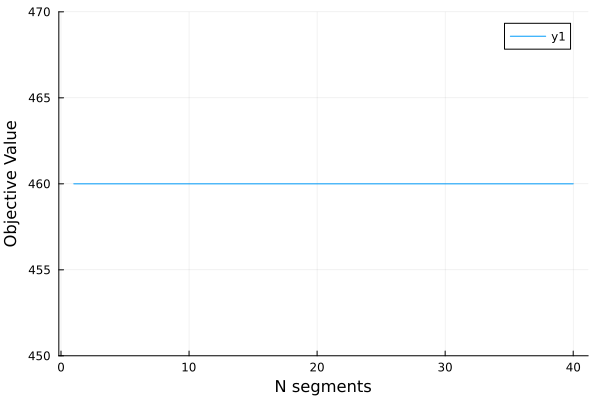

In [11]:
plot(results, xlabel="N segments", ylabel="Objective Value", ylims=(450, 470))